# Notebook for resampling and plotting Gridrad MESH

### Import necessary libraries

In [1]:
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [4]:
import dask
import dask.array as da
from dask import delayed
import dask.dataframe as dd
from dask.distributed import Client
dask.config.set({'temporary_directory': '/home/scratch/jgoodin'})

In [5]:
client = Client() #Set up dask client
client

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33854 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33854/status,
Dashboard: http://127.0.0.1:33854/status,Workers: 8
Total threads: 64,Total memory: 755.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40599,Workers: 8
Dashboard: http://127.0.0.1:33854/status,Total threads: 64
Started: Just now,Total memory: 755.66 GiB
Comm: tcp://127.0.0.1:42570,Total threads: 8
Dashboard: http://127.0.0.1:42843/status,Memory: 94.46 GiB
Nanny: tcp://127.0.0.1:39785,


## Use open_mfdataset to read in all gridrad files (1995-2017, monthly files derived from hourly data)

In [6]:
gridrad = xr.open_mfdataset('/home/scratch/gridrad_mesh/gridrad/*/*/*.nc', parallel = True)

In [7]:
gridrad

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 201624)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1995-01-01 ... 2017-12-31T23:00:00
Data variables:
    SHI        (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

In [ ]:
#gridrad.MESH95.values.max()

## Resample gridrad data to convective daily max

In [8]:
gridrad_daily_max = gridrad.resample(time='24H', base=12).max()

In [9]:
gridrad_daily_max

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 8402)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1994-12-31T12:00:00 ... 2017-12-31T12:00:00
Data variables:
    SHI        (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

### Test plot to check for data and units

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


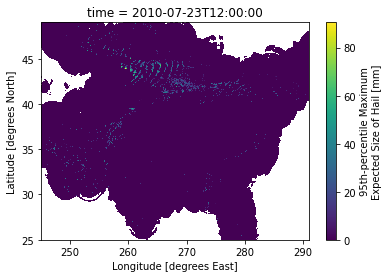

In [10]:
gridrad_daily_max.sel(time = '2010-07-23').MESH95.plot() #Test plot to see what data looks like- Vivian :)

## Convert MESH95 (95th percentile MESH) to units of inches (provided by dataset in mm)

In [11]:
gridrad_inch = gridrad_daily_max * 0.0393701 #Convert to inches

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


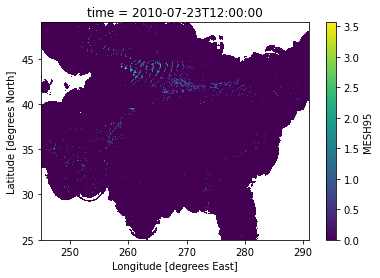

In [12]:
gridrad_inch.sel(time = '2010-07-23').MESH95.plot() #Make sure units are in inches

## Pass severe threshold

In [13]:
gridrad_sev = gridrad_inch.where(gridrad_inch >= 1)

In [ ]:
#gridrad_sev.MESH95.max() 

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


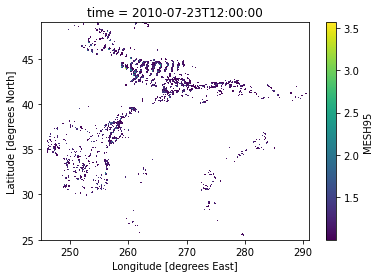

In [14]:
gridrad_sev.sel(time = '2010-07-23').MESH95.plot() #Test plot to make sure dataset contains data

### Groupby year and find max along 'time' dimension and then sum along 'year'. Then find mean annual statistic by dividing by 23

In [15]:
gridrad_annual = gridrad_sev.groupby('time.year').max(dim = 'time').sum(dim = 'year')

In [16]:
gridrad_annual

<xarray.Dataset>
Dimensions:    (Latitude: 1201, Longitude: 2301)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
Data variables:
    SHI        (Latitude, Longitude) float32 dask.array<chunksize=(1201, 2301), meta=np.ndarray>
    MESH75     (Latitude, Longitude) float32 dask.array<chunksize=(1201, 2301), meta=np.ndarray>
    MESH95     (Latitude, Longitude) float32 dask.array<chunksize=(1201, 2301), meta=np.ndarray>

In [17]:
gridrad_annual.MESH95.shape

(1201, 2301)

In [20]:
#gridrad_annual_compute = gridrad_annual.compute() #Use dask's compute function to transform "lazy" computing into in-memory computing

### Divide by 23 to find annual statistic

In [21]:
annual_stat = gridrad_annual / 23

In [ ]:
annual_stat.MESH95.max()

#### Select MESH95 variable to create plottable 2D array

In [22]:
gridrad_plot = annual_stat.MESH95 #**This is a plotting variable**

In [ ]:
#gridrad_plot.values.max()

### Groupby season

In [ ]:
gridrad_seasonal = gridrad_sev.groupby('time.season')

In [ ]:
gridrad_seasonal

### Find max for each season

In [ ]:
gridrad_DJF = gridrad_seasonal['DJF'].max(dim = 'time')
gridrad_MAM = gridrad_seasonal['MAM'].max(dim = 'time')
gridrad_JJA = gridrad_seasonal['JJA'].max(dim = 'time')
gridrad_SON = gridrad_seasonal['SON'].max(dim = 'time')

### Sum along 'time' dimension for each season

In [ ]:
gridrad_DJF_sum = gridrad_DJF.sum(dim = 'time')
gridrad_MAM_sum = gridrad_MAM.sum(dim = 'time')
gridrad_JJA_sum = gridrad_JJA.sum(dim = 'time')
gridrad_SON_sum = gridrad_SON.sum(dim = 'time')

### Compute each season for plotting

In [ ]:
gridrad_DJF_compute = gridrad_DJF_sum.compute()
gridrad_MAM_compute = gridrad_MAM_sum.compute() #Use dask's compute function to transform "lazy" computing into in-memory computing
gridrad_JJA_compute = gridrad_JJA_sum.compute()
gridrad_SON_compute = gridrad_SON_sum.compute()

## Divide by 23 and select MESH95 variable to find seasonal statistic and create plottable 2D array

In [ ]:
gridrad_DJF_plot = gridrad_DJF_compute / 23
gridrad_MAM_plot = gridrad_MAM_compute / 23
gridrad_JJA_plot = gridrad_JJA_compute / 23
gridrad_SON_plot = gridrad_SON_compute / 23

In [ ]:
gridrad_DJF_plot = gridrad_DJF_plot.MESH95
gridrad_MAM_plot = gridrad_MAM_plot.MESH95 #**These are plotting variables**
gridrad_JJA_plot = gridrad_JJA_plot.MESH95
gridrad_SON_plot = gridrad_SON_plot.MESH95

## Repeat all of above steps for monthly

In [ ]:
gridrad_month = gridrad_sev.groupby('time.month')

In [ ]:
gridrad_month

### Find max for each month

In [ ]:
gridrad_Jan = gridrad_month['Jan'].max(dim = 'time')
gridrad_Feb = gridrad_month['Feb'].max(dim = 'time')
gridrad_Mar = gridrad_month['Mar'].max(dim = 'time')
gridrad_Apr = gridrad_month['Apr'].max(dim = 'time')
gridrad_May = gridrad_month['May'].max(dim = 'time')
gridrad_Jun = gridrad_month['Jun'].max(dim = 'time')
gridrad_Jul = gridrad_month['Jul'].max(dim = 'time')
gridrad_Aug = gridrad_month['Aug'].max(dim = 'time')
gridrad_Sep = gridrad_month['Sep'].max(dim = 'time')
gridrad_Oct = gridrad_month['Oct'].max(dim = 'time')
gridrad_Nov = gridrad_month['Nov'].max(dim = 'time')
gridrad_Dec = gridrad_month['Dec'].max(dim = 'time')

## Sum along 'time' dim for each month

In [ ]:
gridrad_Jan_sum = gridrad_Jan.sum(dim = 'time')
gridrad_Feb_sum = gridrad_Feb.sum(dim = 'time')
gridrad_Mar_sum = gridrad_Mar.sum(dim = 'time')
gridrad_Apr_sum = gridrad_Apr.sum(dim = 'time')
gridrad_May_sum = gridrad_May.sum(dim = 'time')
gridrad_Jun_sum = gridrad_Jun.sum(dim = 'time')
gridrad_Jul_sum = gridrad_Jul.sum(dim = 'time')
gridrad_Aug_sum = gridrad_Aug.sum(dim = 'time')
gridrad_Sep_sum = gridrad_Sep.sum(dim = 'time')
gridrad_Oct_sum = gridrad_Oct.sum(dim = 'time')
gridrad_Nov_sum = gridrad_Nov.sum(dim = 'time')
gridrad_Dec_sum = gridrad_Dec.sum(dim = 'time')

### Compute each month

In [ ]:
gridrad_Jan_compute = gridrad_Jan_sum.compute()
gridrad_Feb_compute = gridrad_Feb_sum.compute()
gridrad_Mar_compute = gridrad_Mar_sum.compute()
gridrad_Apr_compute = gridrad_Apr_sum.compute()
gridrad_May_compute = gridrad_May_sum.compute() #Use dask's compute function to transform "lazy" computing into in-memory computing
gridrad_Jun_compute = gridrad_Jun_sum.compute()
gridrad_Jul_compute = gridrad_Jul_sum.compute()
gridrad_Aug_compute = gridrad_Aug_sum.compute()
gridrad_Sep_compute = gridrad_Sep_sum.compute()
gridrad_Oct_compute = gridrad_Oct_sum.compute()
gridrad_Nov_compute = gridrad_Nov_sum.compute()
gridrad_Dec_compute = gridrad_Dec_sum.compute()

## Divide by 23 and select MESH95 variable to create plottable 2D array

In [ ]:
gridrad_Jan_plot = gridrad_Jan_sum / 23
gridrad_Feb_plot = gridrad_Feb_sum / 23
gridrad_Mar_plot = gridrad_Mar_sum / 23
gridrad_Apr_plot = gridrad_Apr_sum / 23
gridrad_May_plot = gridrad_May_sum / 23
gridrad_Jun_plot = gridrad_Jun_sum / 23
gridrad_Jul_plot = gridrad_Jul_sum / 23
gridrad_Aug_plot = gridrad_Aug_sum / 23
gridrad_Sep_plot = gridrad_Sep_sum / 23
gridrad_Oct_plot = gridrad_Oct_sum / 23
gridrad_Nov_plot = gridrad_Nov_sum / 23
gridrad_Dec_plot = gridrad_Dec_sum / 23

In [ ]:
gridrad_Jan_plot = gridrad_Jan_plot.MESH95
gridrad_Feb_plot = gridrad_Feb_plot.MESH95
gridrad_Mar_plot = gridrad_Mar_plot.MESH95
gridrad_Apr_plot = gridrad_Apr_plot.MESH95
gridrad_May_plot = gridrad_May_plot.MESH95
gridrad_Jun_plot = gridrad_Jun_plot.MESH95 #**These are plotting variables**
gridrad_Jul_plot = gridrad_Jul_plot.MESH95
gridrad_Aug_plot = gridrad_Aug_plot.MESH95
gridrad_Sep_plot = gridrad_Sep_plot.MESH95
gridrad_Oct_plot = gridrad_Oct_plot.MESH95
gridrad_Nov_plot = gridrad_Nov_plot.MESH95
gridrad_Dec_plot = gridrad_Dec_plot.MESH95

## Read in WRF HIST data to make comparisons

In [ ]:
wrf_hist = xr.open_dataset('/home/scratch/jgoodin/convective_daily_max_resamples/hist_daily_max_hail_inches.nc')

### Convert data to inches

In [ ]:
hist_inch = wrf_hist * 39.3701 #Convert to in

## Pass severe threshold

In [ ]:
wrf_sev = hist_inch.where(hist_inch >= 1)

In [ ]:
wrf_sev.HAIL_MAX2D.min()

### Groupby year and find max along 'time' dimension and then sum along 'year'. Then find mean annual statistic by dividing by 23

In [ ]:
wrf_annual = wrf_sev.groupby('Time.year').max(dim = 'Time').sum(dim = 'year')

In [ ]:
wrf_annual

### Divide by 15 to find mean annual statistic

In [ ]:
wrf_annual_stat = wrf_annual / 15

### Select HAIL_MAX2D variable

In [ ]:
wrf_annual_plot = wrf_annual_stat.HAIL_MAX2D #**This is a plotting variable**

### Groupby season

In [ ]:
wrf_seasonal = wrf_sev.groupby('Time.season')

### Find max for each season

In [ ]:
wrf_DJF = wrf_seasonal['DJF'].max(dim = 'Time')
wrf_MAM = wrf_seasonal['MAM'].max(dim = 'Time')
wrf_JJA = wrf_seasonal['JJA'].max(dim = 'Time')
wrf_SON = wrf_seasonal['SON'].max(dim = 'Time')

### Sum along 'Time' dimension

In [ ]:
wrf_DJF_sum = wrf_DJF.sum(dim = 'Time')
wrf_MAM_sum = wrf_MAM.sum(dim = 'Time')
wrf_JJA_sum = wrf_JJA.sum(dim = 'Time')
wrf_SON_sum = wrf_SON.sum(dim = 'Time')

## Divide by 15 and select HAIL_MAX2D variable to find seasonal statistic and create plottable 2D array

In [ ]:
wrf_DJF_plot = wrf_DJF_sum / 15
wrf_MAM_plot = wrf_MAM_sum / 15
wrf_JJA_plot = wrf_JJA_sum / 15
wrf_SON_plot = wrf_SON_sum / 15

In [ ]:
wrf_DJF_plot = wrf_DJF_plot.HAIL_MAX2D
wrf_MAM_plot = wrf_MAM_plot.HAIL_MAX2D #**These are plotting variables**
wrf_JJA_plot = wrf_JJA_plot.HAIL_MAX2D
wrf_SON_plot = wrf_SON_plot.HAIL_MAX2D

## Repeat above process for WRF monthly (same as gridrad)

In [ ]:
wrf_month = wrf_sev.groupby('Time.month')

In [ ]:
wrf_month

### Find max value per grid for each month

In [ ]:
wrf_Jan = wrf_month['Jan'].max(dim = 'time')
wrf_Feb = wrf_month['Feb'].max(dim = 'time')
wrf_Mar = wrf_month['Mar'].max(dim = 'time')
wrf_Apr = wrf_month['Apr'].max(dim = 'time')
wrf_May = wrf_month['May'].max(dim = 'time')
wrf_Jun = wrf_month['Jun'].max(dim = 'time')
wrf_Jul = wrf_month['Jul'].max(dim = 'time')
wrf_Aug = wrf_month['Aug'].max(dim = 'time')
wrf_Sep = wrf_month['Sep'].max(dim = 'time')
wrf_Oct = wrf_month['Oct'].max(dim = 'time')
wrf_Nov = wrf_month['Nov'].max(dim = 'time')
wrf_Dec = wrf_month['Dec'].max(dim = 'time')

### Sum along 'Time' dim for each month

In [ ]:
wrf_Jan_sum = wrf_Jan.sum(dim = 'Time')
wrf_Feb_sum = wrf_Feb.sum(dim = 'Time')
wrf_Mar_sum = wrf_Mar.sum(dim = 'Time')
wrf_Apr_sum = wrf_Apr.sum(dim = 'Time')
wrf_May_sum = wrf_May.sum(dim = 'Time')
wrf_Jun_sum = wrf_Jun.sum(dim = 'Time')
wrf_Jul_sum = wrf_Jul.sum(dim = 'Time')
wrf_Aug_sum = wrf_Aug.sum(dim = 'Time')
wrf_Sep_sum = wrf_Sep.sum(dim = 'Time')
wrf_Oct_sum = wrf_Oct.sum(dim = 'Time')
wrf_Nov_sum = wrf_Nov.sum(dim = 'Time')
wrf_Dec_sum = wrf_Dec.sum(dim = 'Time')

## Divide by 15 and select HAIL_MAX2D variable to create plottable 2D array for correct monthly statistics

In [ ]:
wrf_Jan_plot = wrf_Jan_sum / 15
wrf_Feb_plot = wrf_Feb_sum / 15
wrf_Mar_plot = wrf_Mar_sum / 15
wrf_Apr_plot = wrf_Apr_sum / 15
wrf_May_plot = wrf_May_sum / 15
wrf_Jun_plot = wrf_Jun_sum / 15
wrf_Jul_plot = wrf_Jul_sum / 15
wrf_Aug_plot = wrf_Aug_sum / 15
wrf_Sep_plot = wrf_Sep_sum / 15
wrf_Oct_plot = wrf_Oct_sum / 15
wrf_Nov_plot = wrf_Nov_sum / 15
wrf_Dec_plot = wrf_Dec_sum / 15

In [ ]:
wrf_Jan_plot = wrf_Jan_plot.HAIL_MAX2D
wrf_Feb_plot = wrf_Feb_plot.HAIL_MAX2D
wrf_Mar_plot = wrf_Mar_plot.HAIL_MAX2D
wrf_Apr_plot = wrf_Apr_plot.HAIL_MAX2D
wrf_May_plot = wrf_May_plot.HAIL_MAX2D
wrf_Jun_plot = wrf_Jun_plot.HAIL_MAX2D #**These are plotting variables**
wrf_Jul_plot = wrf_Jul_plot.HAIL_MAX2D
wrf_Aug_plot = wrf_Aug_plot.HAIL_MAX2D
wrf_Sep_plot = wrf_Sep_plot.HAIL_MAX2D
wrf_Oct_plot = wrf_Oct_plot.HAIL_MAX2D
wrf_Nov_plot = wrf_Nov_plot.HAIL_MAX2D
wrf_Dec_plot = wrf_Dec_plot.HAIL_MAX2D

## Calculate deltas for each resample between WRF HIST and Gridrad

In [ ]:
annual_delta = wrf_annual_plot - gridrad_plot #Find mean annual mesh delta

In [ ]:
DJF_delta = wrf_DJF_plot - gridrad_DJF_plot
MAM_delta = wrf_MAM_plot - gridrad_MAM_plot #Calculate seasonal deltas
JJA_delta = wrf_JJA_plot - gridrad_JJA_plot
SON_delta = wrf_SON_plot - gridrad_SON_plot

In [ ]:
Jan_delta = wrf_Jan_plot - gridrad_Jan_plot
Feb_delta = wrf_Feb_plot - gridrad_Feb_plot
Mar_delta = wrf_Mar_plot - gridrad_Mar_plot
Apr_delta = wrf_Apr_plot - gridrad_Apr_plot
May_delta = wrf_May_plot - gridrad_May_plot #Calculate monthly deltas
Jun_delta = wrf_Jun_plot - gridrad_Jun_plot
Jul_delta = wrf_Jul_plot - gridrad_Jul_plot
Aug_delta = wrf_Aug_plot - gridrad_Aug_plot
Sep_delta = wrf_Sep_plot - gridrad_Sep_plot
Oct_delta = wrf_Oct_plot - gridrad_Oct_plot
Nov_delta = wrf_Nov_plot - gridrad_Nov_plot
Dec_delta = wrf_Dec_plot - gridrad_Dec_plot

### Make variables for gridrad lats/lons

In [24]:
lats_gridrad = annual_stat.Latitude.values
lons_gridrad = annual_stat.Longitude.values

In [25]:
lats_gridrad.shape

(1201,)

## Repeat for WRF coords

In [ ]:
coords = xr.open_dataset('lat_lon.nc') #Open .nc file containing WRF lat/lon coords

### Assign variables to WRF lats/lons

In [ ]:
lats_wrf = coords.CLAT.values[0, :, :]
lons_wrf = coords.CLONG.values[0, :, :]

## Plot on map of CONUS

In [ ]:
fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
lrFig = ax.pcolormesh(lons_gridrad, lats_gridrad, gridrad_plot, cmap = 'YlOrRd', transform = ccrs.PlateCarree())
gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
gls.top_labels=False
gls.right_labels=False
gls.xlabel_style = {'size': 24, 'rotation': 0}
gls.xpadding = 15.0
gls.ylabel_style = {'size': 24}
plt.title("Gridrad Mean Annual MESH \n 1995 - 2017", fontsize = 44)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, orientation = 'horizontal', extend = 'max')
cb.ax.tick_params(labelsize = 38)
plt.subplots_adjust(bottom=0.07)
#plt.savefig('/home/scratch/jgoodin/gridrad_mean_annual_mesh_size.png')